# Example of *Generating* Compact Representations Using Craspy (results from Araya et al, 2018)


### Mauricio Araya (1), Diego Mardones (2), Marcelo Mendoza (1), Mauricio Solar (1) and Amelia Bayo (3)

(1) Universidad Técnica Federico Santa María <br>
(2) Universidad de Chile <b>
(3) Universidad de Valparaíso

# 1. Introduction

This notebook contains the code for replicating the experiments presented in the paper "Unsupervised learning of structure in spectroscopic cubes". 

### Imports and Initialization

In [1]:
#%matplotlib qt
%matplotlib inline

import craspy

### Downloading Data

Our dataset is composed by a few spectroscopic cubes from the [ALMA Science Verification Dataset](https://almascience.nrao.edu/alma-data/science-verification). The following code download, uncompress and rename the files for its use. *Please remember to create the `data` directory before executing this*.


In [3]:
import os
import urllib.request
import tarfile
from shutil import copyfile

DOWNLOADS_DIR = 'data/'

# Data from ALMA science verification 

# URLs of the tarballs
urls  = ['https://almascience.nrao.edu/almadata/sciver/OrionKLBand6/OrionKL_Band6_ReferenceImages.tgz',
         'https://almascience.nrao.edu/almadata/sciver/TWHya/TWHYA_BAND7_ReferenceImages.tgz',
         'https://bulk.cv.nrao.edu/almadata/sciver/M100Band3_12m/M100_Band3_ReferenceImages_CASA3.3.tgz',
         #'https://bulk.cv.nrao.edu/almadata/sciver/AntennaeBand7/Antennae_Band7_ReferenceImages.tgz',
         'https://almascience.nrao.edu/almadata/sciver/IRAS16293Band6/IRAS16293_Band6_ReferenceImages.tgz']

# Fits names and their "fantasy" names 
flist  = [('Orion.methanol.cbc.contsub.image.fits',          'Orion-CH3OH'),
          ('TWHydra_CO3_2line.image.fits',                   'TWHydra-CO3_2'),
          ('M100line.image.fits',                            'M100-CO1_0'),
          #('Antennae_North.CO3_2Line.Clean.pcal1.image.fits','AntennaeN-CO3'),
          ('I16293_220GHzcorrected.ms.selfcube.image.fits',  'IRAS16293-2422-HCOCH')]

fits_map=dict(zip(urls, flist))

for url,ffile in fits_map.items():
    # Split on the rightmost / and take everything on the right side of that
    name = url.rsplit('/', 1)[-1]
    # Combine the name and the downloads directory to get the local filename
    filename = os.path.join(DOWNLOADS_DIR, name)
    if not os.path.isfile(filename):
        print("Downloading "+str(url))
        urllib.request.urlretrieve(url, filename)
    else:
        print("File found, skipping download of "+str(url))
    sdir=filename.rsplit('ReferenceImages',1)[0]+"ReferenceImages"
    #print(sdir)
    if not os.path.isdir(sdir):
        print("Uncompressing "+str(filename))
        tar = tarfile.open(filename)
        tar.extractall(path=DOWNLOADS_DIR)
        tar.close()
    else:
        print("Directory "+str(sdir)+ " found, not uncompressing")
    copyfile(sdir+"/"+ffile[0], DOWNLOADS_DIR+"/"+ffile[0])

Uncompressing data/OrionKL_Band6_ReferenceImages.tgz
Uncompressing data/TWHYA_BAND7_ReferenceImages.tgz
Uncompressing data/M100_Band3_ReferenceImages_CASA3.3.tgz
Uncompressing data/IRAS16293_Band6_ReferenceImages.tgz


### Dataset Description

The summary of the dimensions and resolutions of the downloaded cubes are obtained using the following extracting function from the FITS metadata.

In [4]:
import numpy as np
from astropy.io import fits
def extract_info(path,ffile):
    # Load fits file  using astropy and convert the primary image into an NDArray
    cube    = craspy.load_ALMA_fits(path+ffile[0])
    valid   = 100*(1.0- (cube.mask.sum()/float(cube.data.size)))
    b_size  = cube.meta['BMIN']
    s_res   = np.abs(cube.meta['CDELT3'])
    a_res   = np.abs(cube.meta['CDELT1'])
    return (ffile[1],cube.data.shape,cube.data.size,valid,a_res,b_size,s_res)

Which are putted in a table for better visualization.

In [5]:
from astropy.table import Table

summary=Table(names=('Name', 
                     '(RA, DEC, FREQ)',
                     'Pixels',
                     'Valid %',
                     'Ang. Res',
                     'Beam Size',
                     'Spec. Res'),
             dtype=('S100',tuple,int,float,float,float,float))

for ffile in flist :
    summary.add_row(vals=extract_info(DOWNLOADS_DIR,ffile))

INFO: Processing PrimaryHDU Object 0 [craspy.fits]


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
  'HZ' -> 'Hz'. [astropy.wcs.wcs]


INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]


Show the table in the notebook and in latex format

In [6]:
summary

Name,"(RA, DEC, FREQ)",Pixels,Valid %,Ang. Res,Beam Size,Spec. Res
bytes100,object,int64,float64,float64,float64,float64
Orion-CH3OH,"(41, 100, 100)",410000,100.0,0.0001111111111111,0.0003823845585187,488336.1207886
TWHydra-CO3_2,"(118, 100, 100)",1180000,100.0,8.333333333333e-05,0.0004255372948117,138414.1518555
M100-CO1_0,"(40, 600, 600)",14400000,57.79547222222222,0.0001388888888889,0.0006894530852636,3906250.0
IRAS16293-2422-HCOCH,"(480, 220, 220)",23232000,53.75826446280991,5.555555555556e-05,0.0002754835618867,488311.0


In [6]:
# Generating the latex table for the paper
from astropy.io import ascii
ascii.write(summary,format='latex') 

\begin{table}
\begin{tabular}{ccccccc}
Name & (RA, DEC, FREQ) & Pixels & Valid % & Ang. Res & Beam Size & Spec. Res \\
Orion-CH3OH & (41, 100, 100) & 410000 & 100.0 & 0.0001111111111111 & 0.0003823845585187 & 488336.1207886 \\
TWHydra-CO3_2 & (118, 100, 100) & 1180000 & 100.0 & 8.333333333333e-05 & 0.0004255372948117 & 138414.1518555 \\
M100-CO1_0 & (40, 600, 600) & 14400000 & 57.79547222222222 & 0.0001388888888889 & 0.0006894530852636 & 3906250.0 \\
IRAS16293-2422-HCOCH & (480, 220, 220) & 23232000 & 53.75826446280991 & 5.555555555556e-05 & 0.0002754835618867 & 488311.0 \\
\end{tabular}
\end{table}


# 2. Signal-to-Noise-Ratio Estimation (SNR)

In this section we show how the signal-to-noise estimation is done.  

<!-- Before doing this we define here a function to plot the results.

### The `plot_snr_estimation()` function
This function plots the thresholded RMS w.r.t. the SNR, including and the selected SNR point. More details below.
-->

In [7]:
#import matplotlib.pyplot as plt

#def plot_snr_estimation(target,snr_results):
#    fig = plt.figure(figsize=(10,4))
#    # Unpack results
#    (slimit,rms,x,y,v,n,p)=snr_results
#    # Plot 
#    ax = fig.add_subplot(1,1,1)
#    ax.plot(x,y,color='b')
#    ax.plot(x,x,color='b',linestyle="--")
#    ax.axvline(x=slimit,color='r',label="$"+str(slimit)+" \sigma$")
#    ax.legend(loc=7)
#    ax.set_title(target)
#    ax.set_xlabel("SNR ($ \\tau / \sigma$)")
#    ax.set_ylabel('RMS', color='b')
#    for tl in ax.get_yticklabels():
#        tl.set_color('b')
#    axp = ax.twinx()
#    axp.plot(x[:-1],v,color='grey')
#    axp.set_ylabel('$\Delta$RMS', color='grey')
#    for tl in axp.get_yticklabels():
#        tl.set_color('grey')
#    plt.show()
    

### Compute, store and plot the estimations
The fluxes of each cube are standardized in the $[0,1]$ range to ensure numerical stability using the function `craspy.standarize`. Then, the parameter $\sigma$ of the algorithm is estimated as the RMS of the cube and an estimation of the signal-to-noise ratio is performed to obtain the $\tau$ parameter by using function `craspy.snr_estimation()`. Then we plot the results using the `plot_snr_estimation()` function. This function plots the thresholded RMS w.r.t. the SNR, including and the selected SNR point. At last, we compute the theoretical bound reported in the paper:
\begin{equation*}
\frac{F_\tau - n_\tau(\tau - \sigma)}{\sigma}
\end{equation*}
and store the results into a table.

INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/flux.py:204: RuntimeWarning: invalid value encountered in greater
  sdata = data[data > noise]
/Users/mauricio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


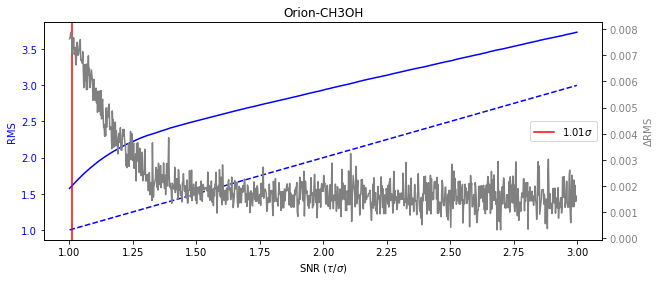

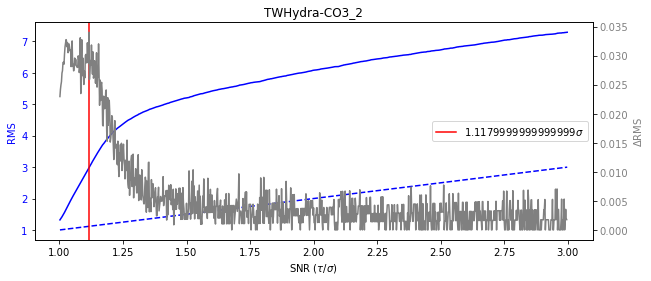

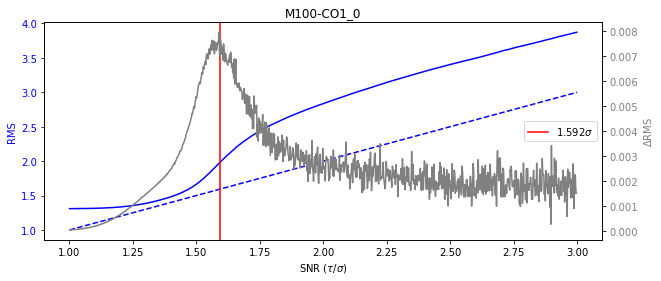

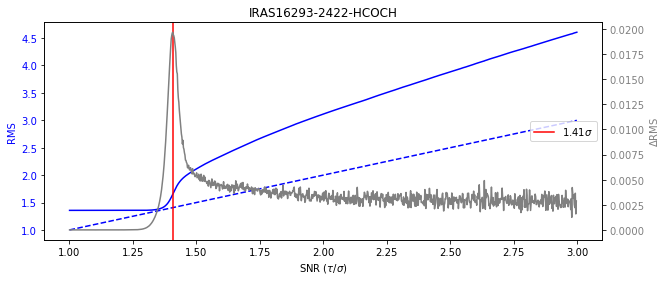

In [7]:
# Define the snr_table elements
snr_table=Table(names=('Name', 
                       'RMS',
                       'SNR',
                       'N_max'),
             dtype=('S100',float,float,float))

for ffile in flist:
    
    # Read file
    cube    = craspy.load_ALMA_fits(DOWNLOADS_DIR+ffile[0])
    target  = ffile[1]
    
    # Process it
    (cube,ym,yf)=craspy.standarize(cube)
    result=craspy.snr_estimation(cube.data,mask=cube.mask,points=1000,full_output=True)
    # Display it
    craspy.plot_snr_estimation(target,result)
    
    # Unpack, and compute the theoretical maximum number of elements 
    (slimit,rms,x,y,v,n,p)=result
    F=cube.data[cube.data>slimit*rms]
    nt=F.shape[0]
    Ft=F.sum()
    nest=(Ft - nt*(slimit*rms - rms))/rms
    snr_table.add_row(vals=(target,rms,slimit,nest))

The blue lines correspond to the RMS computed after
thresholding the cube using $\tau$. The dotted line is the lowest value that the
RMS can take, the grey line shows the slope of the RMS and the red line is the
SNR selected by the heuristic.

### Summary table

In [9]:
snr_table

Name,RMS,SNR,N_max
bytes100,float64,float64,float64
Orion-CH3OH,2.607718957793632e-06,1.01,66983.25293068717
TWHydra-CO3_2,8.994790676787981e-07,1.1179999999999999,25850.200216335455
M100-CO1_0,9.180942279785339e-08,1.592,103608.13682425409
IRAS16293-2422-HCOCH,5.8952157086025623e-08,1.41,348146.14870935713


# 3. Pixel-based Homogeneous Representation (PHB)

This section shows some graphical results for a pixel-based homogeneous representation.

### Graphical layout
To show these results we require some "advanced" matplotlib configurations to improve the visualization.

In [8]:
import matplotlib.ticker as ticker
import matplotlib as mpl
from matplotlib import gridspec
mpl.rcParams['axes.formatter.limits']=(-5,5)
def fmt(x, pos):
    return '{:.1e}'.format(x)

For each file we will produce 4 plots:
* The original zeroth moment of the cube (`orig2D`)
* The signal (i.e. synthethic) zeroth moment of the cube (`syn2D`)
* The residual (i.e. original - signal) zeroth moment of the cube (`res2D`)
* The integrated spectrum of the these three cubes (`origSpec`,`synSpec`,`resSpec`)

The following large function plots these elements starting from the `cube`, `syn` and `res` data. Most of the code is only for a proper visualization.

In [9]:

def plot_algo_result(target,cube,syn,res):
    ### Stylistic configurations ###
    cmap="seismic"
    origin="lower"
  
    # Relative sizes of the subfigure
    fig = plt.figure(target,figsize=(10,5))
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1 , 2]) 
    ### END ###
    
    # Obtain the zeroth moments
    orig2D=craspy.moment0(cube)
    syn2D=craspy.moment0(syn,wcs=cube.wcs,mask=cube.mask,unit=cube.unit)
    res2D=craspy.moment0(res,wcs=cube.wcs,mask=cube.mask,unit=cube.unit)
    
    # Shared colormap minimum and maximum values
    vmin=0
    vmax=orig2D.data.max()
    
    # Obtain the spectra
    origSpec=np.nansum(cube.data,axis=(1,2))
    synSpec=syn.data.sum(axis=(1,2))
    resSpec=res.data.sum(axis=(1,2))
    
    # First image with WCS and name
    ax1  = plt.subplot(gs[0],projection=orig2D.wcs)
    ob=ax1.imshow(orig2D.data,origin=origin,vmin=vmin,vmax=vmax,cmap=cmap)
    ax1.set_title("Original")
    ax1.set_ylabel(target)
   
    # Second image without WCS
    ax2  = plt.subplot(gs[1])
    ax2.imshow(syn2D.data,origin=origin,vmin=vmin,vmax=vmax,cmap=cmap)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_title("Signal")
    
    # Third image without WCS
    ax3  = plt.subplot(gs[2])
    ax3.imshow(res2D.data,origin=origin,vmin=vmin,vmax=vmax,cmap=cmap)
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    ax3.set_title("Residual")

    # Add a colorbar
    cb=fig.colorbar(ob,ax=[ax1,ax2,ax3], format=ticker.FuncFormatter(fmt))
    cb.set_label("Flux")
    
    # Plot the 3 spectra with proper velocity values (from cube's resfrq)
    ax4  = plt.subplot(gs[3])
    ranges = craspy.extent(cube)
    vel = np.linspace(ranges[0][0], ranges[1][0], cube.data.shape[0])
    ax4.plot(vel,origSpec,color='k',label='Original')
    ax4.plot(vel,resSpec,color='k',linestyle="--",label='Residual')
    ax4.set_xlabel("Velocity [km/s]")
    ax4.set_ylabel("Flux")
    for tl in ax4.get_yticklabels():
        tl.set_color('k')
    ax5=ax4.twinx()
    ax5.plot(vel,synSpec,color='b',label='Signal',linewidth=2.0)
    for tl in ax5.get_yticklabels():
        tl.set_color('b')
    ax4.legend(loc=2)
    ax5.legend(loc=1)
    plt.show()


### PHB Representation Results


INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data=data[_slab(data,upper,lower)]


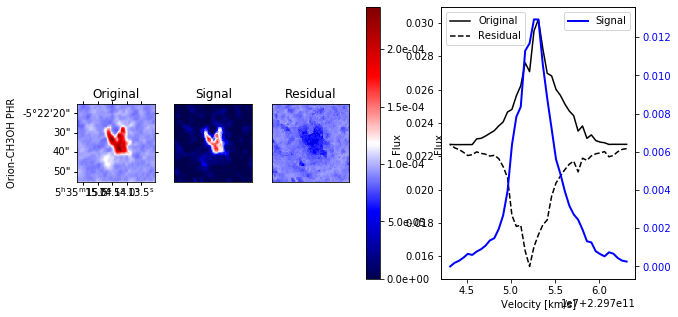

INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
  'HZ' -> 'Hz'. [astropy.wcs.wcs]
/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data=data[_slab(data,upper,lower)]


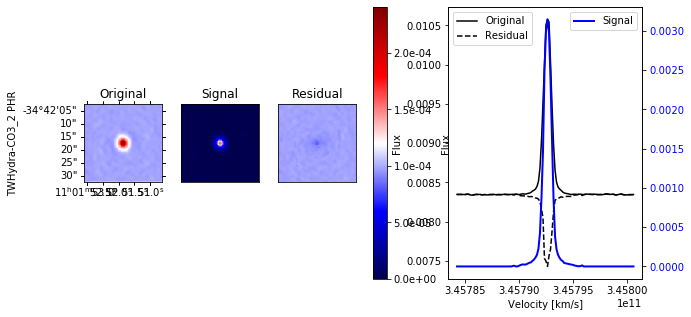

INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data=data[_slab(data,upper,lower)]
/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:78: RuntimeWarning: invalid value encountered in greater
  ff=np.where(data>threshold)


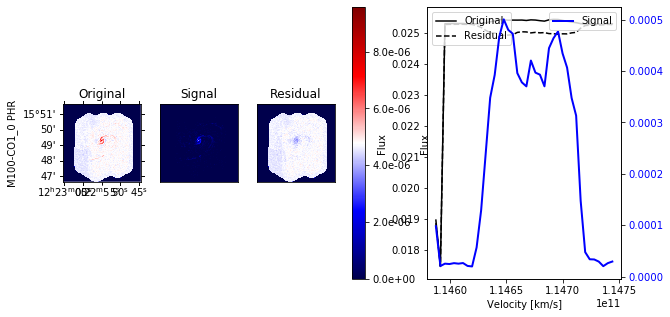

INFO: Processing PrimaryHDU Object 0 [craspy.fits]


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data=data[_slab(data,upper,lower)]
/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:78: RuntimeWarning: invalid value encountered in greater
  ff=np.where(data>threshold)


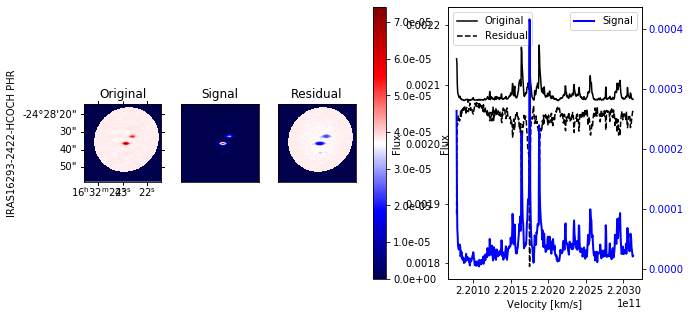

In [10]:
from matplotlib import gridspec
import matplotlib.pyplot as plt
rep_size=[]
bound=[]
count=0
for ffile in flist:
    
    cube    = craspy.load_ALMA_fits(DOWNLOADS_DIR+ffile[0])
    target  = ffile[1]
  
    (cube,ym,yf)=craspy.standarize(cube)

    hrep = craspy.HRep()
    hrep.set_param('RMS',snr_table['RMS'][count])
    hrep.set_param('SNR',snr_table['SNR'][count])
    hrep.set_param('KERNEL','PIXEL')
    (rep,syn,res) = hrep.run(cube)
   
    mynoise=snr_table['RMS'][count]
    mythresh=mynoise*snr_table['SNR'][count]
    mmmask=(syn.data>0)
    nnn=syn.data[mmmask].size
    ft=np.nansum(syn.data[mmmask] + res.data[mmmask]) 
    
    bound.append(int((ft -nnn*(mythresh - mynoise))/mynoise))
    rep_size.append(rep.as_array().size)
    
    plot_algo_result(target+" PHR",cube,syn,res)
    
    count+=1

### PHR dimensions
Here we present the number of points needed by a PHR solution given the computed SNR, and we compare it with respect to the theoretical bound and the number of valid pixels of the image. Also, the latex version of the table is printed.

In [11]:
from astropy.table import Column
phr_table=snr_table.copy()
rbound=Column((np.array(rep_size)*100/np.array(bound))/100.0,name="Pts/Bound")
elms=Column(rep_size,name="Pts")
pval=np.array(rep_size)/(summary['Pixels']*(summary['Valid %']/100.0))
pval.name="Pts/Valid"
phr_table.remove_column('N_max')
phr_table.add_columns((elms,rbound,pval))
phr_table

Name,RMS,SNR,Pts,Pts/Bound,Pts/Valid
bytes100,float64,float64,int64,float64,float64
Orion-CH3OH,2.607718957793632e-06,1.01,55964,0.8354955735037248,0.13649756097560975
TWHydra-CO3_2,8.994790676787981e-07,1.1179999999999999,23796,0.920541586073501,0.020166101694915253
M100-CO1_0,9.180942279785339e-08,1.592,101889,0.9834181088150414,0.01224252476525218
IRAS16293-2422-HCOCH,5.8952157086025623e-08,1.41,328057,0.9422620124713135,0.026267423165122927


In [14]:
ascii.write(phr_table,format='latex')

\begin{table}
\begin{tabular}{cccccc}
Name & RMS & SNR & Pts & Pts/Bound & Pts/Valid \\
Orion-CH3OH & 2.607718957793632e-06 & 1.01 & 55964 & 0.8354955735037248 & 0.13649756097560975 \\
TWHydra-CO3_2 & 8.994790676787981e-07 & 1.1179999999999999 & 23796 & 0.920541586073501 & 0.020166101694915253 \\
M100-CO1_0 & 9.180942279785339e-08 & 1.592 & 101889 & 0.9834181088150414 & 0.01224252476525218 \\
IRAS16293-2422-HCOCH & 5.8952157086025623e-08 & 1.41 & 328057 & 0.9422620124713135 & 0.026267423165122927 \\
\end{tabular}
\end{table}


## 4. Gaussian-based Homogeneous Representation (GHR)

In [12]:
def camera_ready_algo_result(target,cube,syn,res,synP,resP):
    ### Stylistic configurations ###
    cmap="seismic"
    origin="lower"
  
    # Relative sizes of the subfigure
    fig = plt.figure(target)#,figsize=(10,5))
    gs = gridspec.GridSpec(1, 5)# width_ratios=[1, 1, 1 , 1,1], height_ratios=[1,1,1,1,1]) 
    ### END ###
    
    # Obtain the zeroth moments
    orig2D=craspy.moment0(cube)
    syn2D=craspy.moment0(syn,wcs=cube.wcs,mask=cube.mask,unit=cube.unit)
    res2D=craspy.moment0(res,wcs=cube.wcs,mask=cube.mask,unit=cube.unit)
    
    synP2D=craspy.moment0(synP,wcs=cube.wcs,mask=cube.mask,unit=cube.unit)
    resP2D=craspy.moment0(resP,wcs=cube.wcs,mask=cube.mask,unit=cube.unit)
    

    # Shared colormap minimum and maximum values
    vmin=0
    vmax=orig2D.data.max()
    
    # Obtain the spectra
    origSpec=np.nansum(cube.data,axis=(1,2))
    synSpec=syn.data.sum(axis=(1,2))
    resSpec=res.data.sum(axis=(1,2))
    synPSpec=synP.data.sum(axis=(1,2))
    resPSpec=resP.data.sum(axis=(1,2))
    
    
    # First image with WCS and name
    ax1  = plt.subplot(gs[0],projection=orig2D.wcs)
    ob=ax1.imshow(orig2D.data,origin=origin,vmin=vmin,vmax=vmax,cmap=cmap)
    ax1.set_title("Original")
    ax1.set_ylabel(target)
   
    # Second image without WCS
    ax2  = plt.subplot(gs[1])
    ax2.imshow(synP2D.data,origin=origin,vmin=vmin,vmax=vmax,cmap=cmap)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_title("PHR Signal")
  
 
    ax3  = plt.subplot(gs[2])
    ax3.imshow(syn2D.data,origin=origin,vmin=vmin,vmax=vmax,cmap=cmap)
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    ax3.set_title("GHR Signal")

    ax4  = plt.subplot(gs[3])
    ax4.imshow(resP2D.data,origin=origin,vmin=vmin,vmax=vmax,cmap=cmap)
    ax4.get_xaxis().set_visible(False)
    ax4.get_yaxis().set_visible(False)
    ax4.set_title("PHR Residual")
 
    ax5  = plt.subplot(gs[4])
    ax5.imshow(res2D.data,origin=origin,vmin=vmin,vmax=vmax,cmap=cmap)
    ax5.get_xaxis().set_visible(False)
    ax5.get_yaxis().set_visible(False)
    ax5.set_title("GHR Residual")

    # Add a colorbar
    cb=fig.colorbar(ob,ax=[ax1,ax2,ax3,ax4,ax5], format=ticker.FuncFormatter(fmt))
    cb.set_label("Flux")
    plt.show()
    plt.figure()    
    # Plot the 3 spectra with proper velocity values (from cube's resfrq)
    axn  = plt.subplot(1,1,1)
    ranges = craspy.extent(cube)
    vel = np.linspace(ranges[0][0], ranges[1][0], cube.data.shape[0])
    axn.plot(vel,origSpec,color='k',label='Original',linewidth=2.0)
    axn.plot(vel,resPSpec,color='b',label='PHR Residual',linewidth=2.0)
    axn.plot(vel,resSpec,color='r',label='GHR Residual',linewidth=2.0)
    axn.set_xlabel("Velocity [km/s]")
    axn.set_ylabel("Flux")
    for tl in axn.get_yticklabels():
        tl.set_color('k')
    axnp=axn.twinx()
    axnp.plot(vel,synPSpec,color='b',linestyle=":",label='PHR Signal',linewidth=2.0)
    axnp.plot(vel,synSpec,color='r',linestyle=":",label='GHR Signal',linewidth=2.0)
    for tl in axnp.get_yticklabels():
        tl.set_color('Gray')
    axn.legend(loc=2)
    axnp.legend(loc=1)
    plt.show()    
    
    #axn  = plt.subplot(2,1,2)
    #ranges = aca.extent(cube)
    #vel = np.linspace(ranges[0][0], ranges[1][0], cube.data.shape[0])
    #axn.plot(vel,origSpec,color='k',label='Original')
    #axn.plot(vel,resSpec,color='k',linestyle="--",label='Residual')
    #axn.set_xlabel("Velocity [km/s]")
    #axn.set_ylabel("Flux")
    #for tl in axn.get_yticklabels():
    #    tl.set_color('k')
    #axnp=axn.twinx()
    #axnp.plot(vel,synSpec,color='b',label='Signal',linewidth=2.0)
    #for tl in axnp.get_yticklabels():
    #    tl.set_color('b')
    #axn.legend(loc=2)
    #axnp.legend(loc=1)


INFO: Processing PrimaryHDU Object 0 [craspy.fits]


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data=data[_slab(data,upper,lower)]


INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
INFO: Standarizing Cube... [craspy.hrep]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
INFO: Computing Delta... [craspy.hrep]
CPU times: user 554 ms, sys: 9.4 ms, total: 563 ms
Wall time: 564 ms
INFO: Standarizing Cube... [craspy.hrep]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
INFO: Computing Delta... [craspy.hrep]
INFO: Computing Mould... [craspy.hrep]
INFO: Ready to rumble... [craspy.hrep]
INFO: Residual copy built [craspy.homogen]
INFO: Energy copy built [craspy.homogen]
INFO: Synthetic matrix built [craspy.homogen]
INFO: Populating Energy Matrix for the first time (it might take a while) [craspy.homogen]


/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mcb=residual[_slab(residual, lb, ub)]
/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:44: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  dset=np.vstack({tuple(row) for row in dset})
/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

INFO: Iteration: 1000 [craspy.homogen]
INFO: Maximum energy E = 7.130025e-06 SNR = 2.7341999701495645 [craspy.homogen]
INFO: Iteration: 2000 [craspy.homogen]
INFO: Maximum energy E = 5.403584e-06 SNR = 2.0721496995392785 [craspy.homogen]
INFO: Iteration: 3000 [craspy.homogen]
INFO: Maximum energy E = 4.2853344e-06 SNR = 1.6433267801496227 [craspy.homogen]
INFO: Iteration: 4000 [craspy.homogen]
INFO: Maximum energy E = 3.49839e-06 SNR = 1.3415517820873273 [craspy.homogen]
INFO: Iteration: 5000 [craspy.homogen]
INFO: Maximum energy E = 3.0250221e-06 SNR = 1.1600261275498749 [craspy.homogen]
INFO: Iteration: 6000 [craspy.homogen]
INFO: Maximum energy E = 2.7749197e-06 SNR = 1.0641176317204402 [craspy.homogen]
INFO: Iteration: 7000 [craspy.homogen]
INFO: Maximum energy E = 2.637356e-06 SNR = 1.0113650903792322 [craspy.homogen]
INFO: Criterion Met: SNR=1.009968004090183<1.01 [craspy.homogen]
CPU times: user 42.4 s, sys: 229 ms, total: 42.7 s
Wall time: 42.9 s


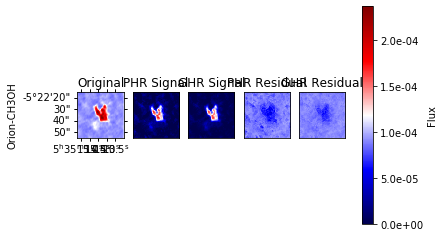

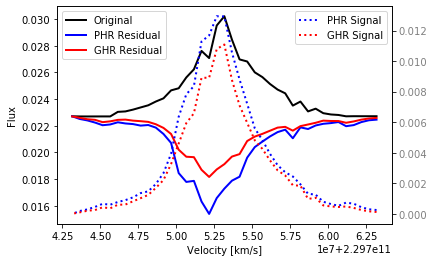

INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
INFO: Standarizing Cube... [craspy.hrep]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
INFO: Computing Delta... [craspy.hrep]


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
  'HZ' -> 'Hz'. [astropy.wcs.wcs]
/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data=data[_slab(data,upper,lower)]


CPU times: user 148 ms, sys: 5.87 ms, total: 154 ms
Wall time: 155 ms
INFO: Standarizing Cube... [craspy.hrep]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
INFO: Computing Delta... [craspy.hrep]
INFO: Computing Mould... [craspy.hrep]
INFO: Ready to rumble... [craspy.hrep]
INFO: Residual copy built [craspy.homogen]
INFO: Energy copy built [craspy.homogen]
INFO: Synthetic matrix built [craspy.homogen]
INFO: Populating Energy Matrix for the first time (it might take a while) [craspy.homogen]


/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mcb=residual[_slab(residual, lb, ub)]
/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:44: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  dset=np.vstack({tuple(row) for row in dset})
/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

INFO: Iteration: 1000 [craspy.homogen]
INFO: Maximum energy E = 1.999046e-06 SNR = 2.222448533646344 [craspy.homogen]
INFO: Criterion Met: SNR=1.1174476759093006<1.1179999999999999 [craspy.homogen]
CPU times: user 19 s, sys: 123 ms, total: 19.1 s
Wall time: 19.2 s


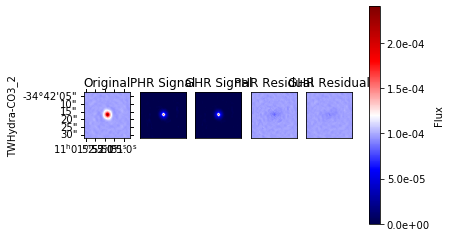

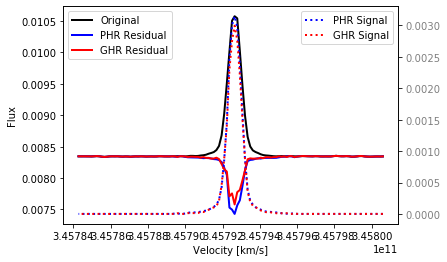

INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
INFO: Standarizing Cube... [craspy.hrep]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
INFO: Computing Delta... [craspy.hrep]


/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data=data[_slab(data,upper,lower)]
/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:78: RuntimeWarning: invalid value encountered in greater
  ff=np.where(data>threshold)


CPU times: user 1.26 s, sys: 86.1 ms, total: 1.35 s
Wall time: 1.36 s
INFO: Standarizing Cube... [craspy.hrep]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
INFO: Computing Delta... [craspy.hrep]
INFO: Computing Mould... [craspy.hrep]
INFO: Ready to rumble... [craspy.hrep]
INFO: Residual copy built [craspy.homogen]
INFO: Energy copy built [craspy.homogen]
INFO: Synthetic matrix built [craspy.homogen]
INFO: Populating Energy Matrix for the first time (it might take a while) [craspy.homogen]


/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mcb=residual[_slab(residual, lb, ub)]
/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:44: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  dset=np.vstack({tuple(row) for row in dset})
/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

INFO: Iteration: 1000 [craspy.homogen]
INFO: Maximum energy E = 2.9891373e-07 SNR = 3.255806689199831 [craspy.homogen]
INFO: Iteration: 2000 [craspy.homogen]
INFO: Maximum energy E = 2.388268e-07 SNR = 2.601332116420793 [craspy.homogen]
INFO: Iteration: 3000 [craspy.homogen]
INFO: Maximum energy E = 2.0488038e-07 SNR = 2.2315833504339686 [craspy.homogen]
INFO: Iteration: 4000 [craspy.homogen]
INFO: Maximum energy E = 1.83351e-07 SNR = 1.9970826512338333 [craspy.homogen]
INFO: Iteration: 5000 [craspy.homogen]
INFO: Maximum energy E = 1.6945516e-07 SNR = 1.8457273515787416 [craspy.homogen]
INFO: Iteration: 6000 [craspy.homogen]
INFO: Maximum energy E = 1.605703e-07 SNR = 1.7489522310986008 [craspy.homogen]
INFO: Iteration: 7000 [craspy.homogen]
INFO: Maximum energy E = 1.5544043e-07 SNR = 1.693077108475316 [craspy.homogen]
INFO: Iteration: 8000 [craspy.homogen]
INFO: Maximum energy E = 1.5221879e-07 SNR = 1.6579865556941067 [craspy.homogen]
INFO: Iteration: 9000 [craspy.homogen]
INFO: Ma

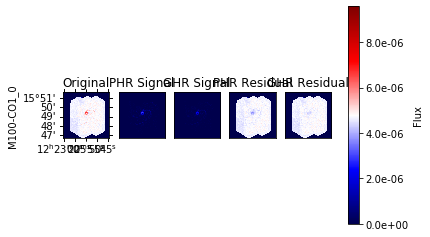

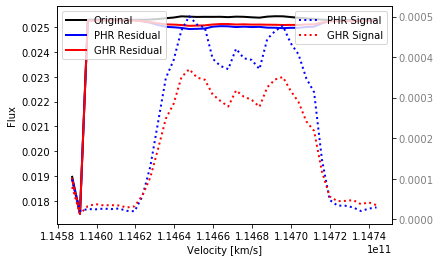

INFO: Processing PrimaryHDU Object 0 [craspy.fits]


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
INFO: Standarizing Cube... [craspy.hrep]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
INFO: Computing Delta... [craspy.hrep]


/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data=data[_slab(data,upper,lower)]
/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:78: RuntimeWarning: invalid value encountered in greater
  ff=np.where(data>threshold)


CPU times: user 4.01 s, sys: 207 ms, total: 4.22 s
Wall time: 4.29 s
INFO: Standarizing Cube... [craspy.hrep]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
INFO: Computing Delta... [craspy.hrep]
INFO: Computing Mould... [craspy.hrep]
INFO: Ready to rumble... [craspy.hrep]
INFO: Residual copy built [craspy.homogen]
INFO: Energy copy built [craspy.homogen]
INFO: Synthetic matrix built [craspy.homogen]
INFO: Populating Energy Matrix for the first time (it might take a while) [craspy.homogen]


/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mcb=residual[_slab(residual, lb, ub)]
/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:44: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  dset=np.vstack({tuple(row) for row in dset})
/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

INFO: Iteration: 1000 [craspy.homogen]
INFO: Maximum energy E = 3.1910187e-07 SNR = 5.412895605695324 [craspy.homogen]
INFO: Iteration: 2000 [craspy.homogen]
INFO: Maximum energy E = 2.309901e-07 SNR = 3.918263687054737 [craspy.homogen]
INFO: Iteration: 3000 [craspy.homogen]
INFO: Maximum energy E = 1.8968116e-07 SNR = 3.217544005916644 [craspy.homogen]
INFO: Iteration: 4000 [craspy.homogen]
INFO: Maximum energy E = 1.644139e-07 SNR = 2.788937892010991 [craspy.homogen]
INFO: Iteration: 5000 [craspy.homogen]
INFO: Maximum energy E = 1.4676897e-07 SNR = 2.489628468047221 [craspy.homogen]
INFO: Iteration: 6000 [craspy.homogen]
INFO: Maximum energy E = 1.3382132e-07 SNR = 2.2699986448216873 [craspy.homogen]
INFO: Iteration: 7000 [craspy.homogen]
INFO: Maximum energy E = 1.2405937e-07 SNR = 2.1044076270002883 [craspy.homogen]
INFO: Iteration: 8000 [craspy.homogen]
INFO: Maximum energy E = 1.1604773e-07 SNR = 1.9685069280615914 [craspy.homogen]
INFO: Iteration: 9000 [craspy.homogen]
INFO: Ma

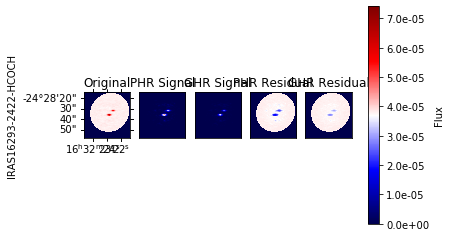

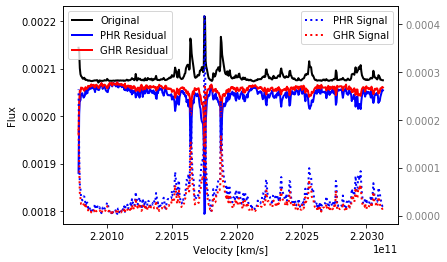

In [13]:
count=0
results=[]
syn_list=[]
#ener_list =[]
resi_list=[]
for ffile in flist:
    # Preparing data
    cube    = craspy.load_ALMA_fits(DOWNLOADS_DIR+ffile[0])
    target  = ffile[1]
    (cube,ym,yf)=craspy.standarize(cube)
    mynoise=snr_table['RMS'][count]
    mythresh=mynoise*snr_table['SNR'][count]
    
    # Compute mould
    #spa=np.ceil((np.abs(cube.meta['BMIN']/cube.meta['CDELT1']) - 1)/2.0)
    #delta=[1,spa,spa]
    #P=precision_from_delta(delta,0.1)
    #mould=create_mould(P,delta)
    
    # Create representation
    
    phr_rep = craspy.HRep()
    phr_rep.set_param('RMS',snr_table['RMS'][count])
    phr_rep.set_param('SNR',snr_table['SNR'][count])
    phr_rep.set_param('KERNEL','PIXEL')
    phr_rep.set_param('VERBOSE',True)
 
    ghr_rep = craspy.HRep()
    ghr_rep.set_param('RMS',snr_table['RMS'][count])
    ghr_rep.set_param('SNR',snr_table['SNR'][count])
    ghr_rep.set_param('KERNEL','METABUBBLE')
    ghr_rep.set_param('VERBOSE',True)
 

    %time (repP,synP,resP) = phr_rep.run(cube)
    %time (rep,syn,res) = ghr_rep.run(cube)
    #%time (repP,synP,resP)=scat_pix_detect(cube.data,threshold=mythresh,noise=mynoise,full_output=True)
    #%time (rep,syn,res,ener,elist)=bubble_detect(cube.data,meta=cube.meta,threshold=mythresh,noise=mynoise,full_output=True,verbose=True)
    
    camera_ready_algo_result(target,cube,syn,res,synP,resP)
    results.append(rep)
    syn_list.append(syn)
    #ener_list.append(elist)
    resi_list.append(res)
    count+=1

### Summary table

In [24]:
ghr_table=phr_table.copy()
rep_size=[]
for rep in results:
    rep_size.append(rep.as_array().size)
    #rep_size.append(res.size)
print(rep_size)
rbound=Column((np.array(rep_size)*100/np.array(bound))/100.0,name="Pts/Bound")
elms=Column(rep_size,name="Pts")
pval=np.array(rep_size)/(summary['Pixels']*(summary['Valid %']/100.0))
pval.name="Pts/Valid"
pthr=np.array(rep_size)/phr_table["Pts"]
pthr.name="Pts/Phr"
ghr_table.remove_column('Pts')
ghr_table.remove_column('Pts/Valid')
ghr_table.remove_column('Pts/Bound')
ghr_table.add_columns((elms,rbound,pthr,pval))
ghr_table

[7026, 1550, 12098, 34513]


Name,RMS,SNR,Pts,Pts/Bound,Pts/Phr,Pts/Valid
bytes100,float64,float64,int64,float64,float64,float64
Orion-CH3OH,2.607718957793632e-06,1.01,7026,0.1048922861024439,0.12554499320992066,0.01713658536585366
TWHydra-CO3_2,8.994790676787981e-07,1.1179999999999999,1550,0.059961315280464215,0.06513699781475878,0.0013135593220338984
M100-CO1_0,9.180942279785339e-08,1.592,12098,0.11676817203470807,0.11873705699339478,0.001453641360794795
IRAS16293-2422-HCOCH,5.8952157086025623e-08,1.41,34513,0.09912999520334101,0.10520427852476856,0.0027634453027915503


In [25]:
ascii.write(ghr_table,format='latex')

\begin{table}
\begin{tabular}{ccccccc}
Name & RMS & SNR & Pts & Pts/Bound & Pts/Phr & Pts/Valid \\
Orion-CH3OH & 2.607718957793632e-06 & 1.01 & 7026 & 0.1048922861024439 & 0.12554499320992066 & 0.01713658536585366 \\
TWHydra-CO3_2 & 8.994790676787981e-07 & 1.1179999999999999 & 1550 & 0.059961315280464215 & 0.06513699781475878 & 0.0013135593220338984 \\
M100-CO1_0 & 9.180942279785339e-08 & 1.592 & 12098 & 0.11676817203470807 & 0.11873705699339478 & 0.001453641360794795 \\
IRAS16293-2422-HCOCH & 5.8952157086025623e-08 & 1.41 & 34513 & 0.09912999520334101 & 0.10520427852476856 & 0.0027634453027915503 \\
\end{tabular}
\end{table}


## Save the results!

In [18]:
from astropy.nddata import NDData
#ascii.write(ghr_table, 'GHR-Summary.dat')
#ascii.write(phr_table, 'PHR-Summary.dat')
#ascii.write(summary,'Data-Summary.dat')
#ascii.write(snr_table,'SNR-Summary.dat')
for i in range(len(flist)):
    # Convert Results to savable table
    #rep=results[i]['center'].data
    ffile=flist[i]
    name=ffile[1]
    #ascii.write(results[i],"REP-"+name+".dat")
    cube = craspy.load_ALMA_fits(DOWNLOADS_DIR+ffile[0])
    img=syn_list[i]
    hdu = craspy.Data_to_HDU(img,primary=True)
    hdu.writeto("SYN-"+name+".fits",clobber=True)
    img=resi_list[i]
    hdu = craspy.Data_to_HDU(img,primary=True)
    hdu.writeto("RES-"+name+".fits",clobber=True)

INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]


INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]


In [33]:
results

[<Table length=7026>
   x     y     z  
 int64 int64 int64
 ----- ----- -----
    19    52    46
    19    46    49
    23    44    53
    17    58    54
    21    46    52
    21    51    45
    17    54    45
    18    52    45
    21    43    54
    18    54    44
   ...   ...   ...
    23    91    94
    23    51    16
     4     3    39
    35    38    54
    25     3    73
     9    36    95
    25    52    87
     8    58    39
    12    53    67
     5    61    57, <Table length=1550>
   x     y     z  
 int64 int64 int64
 ----- ----- -----
    55    51    51
    60    47    49
    59    47    49
    54    52    51
    59    48    48
    55    52    50
    60    47    48
    54    51    51
    55    51    51
    60    47    49
   ...   ...   ...
    68    46    50
    56    47     9
    57    85    76
    57    25    25
    59    14    45
    57    17    31
    58    52    21
    61    74    86
    59    95    80
    70    48    52, <Table length=12098>
   x     y     z  
 int6

### Differences between representations

INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data=data[_slab(data,upper,lower)]


INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


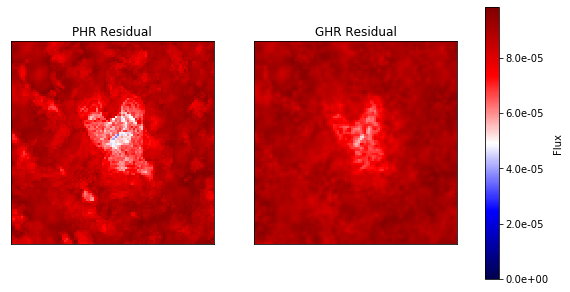

INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


  'HZ' -> 'Hz'. [astropy.wcs.wcs]


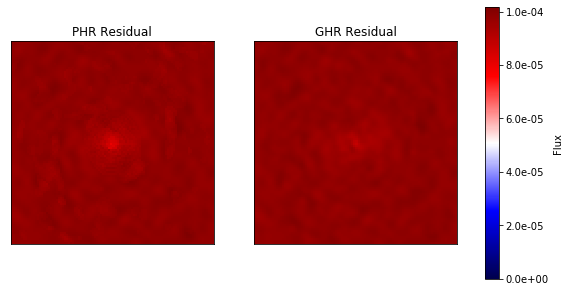

INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


/Users/mauricio/Dropbox/Notebooks/research/fresh/craspy/craspy/homogen.py:78: RuntimeWarning: invalid value encountered in greater
  ff=np.where(data>threshold)


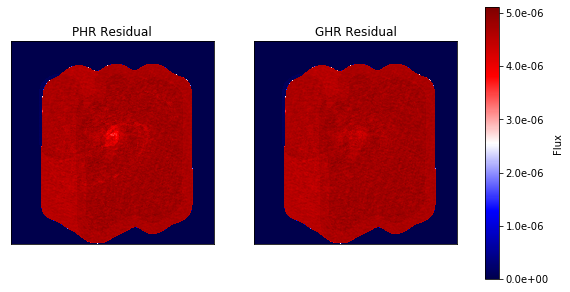

INFO: Processing PrimaryHDU Object 0 [craspy.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [craspy.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


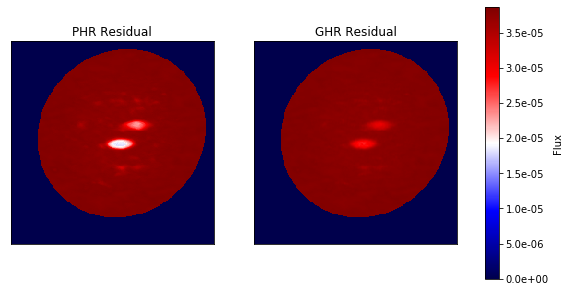

In [14]:

cmap="seismic"
origin="lower"

for ite in range(len(results)):
    (filename,target)=flist[ite]
    cube = craspy.load_ALMA_fits(DOWNLOADS_DIR+filename)
    target  = ffile[1]
    (cube,ym,yf)=craspy.standarize(cube)
    mynoise=snr_table['RMS'][ite]
    mythresh=mynoise*snr_table['SNR'][ite]
    resBub=resi_list[ite]
    hrep = craspy.HRep()
    hrep.set_param('RMS',snr_table['RMS'][ite])
    hrep.set_param('SNR',snr_table['SNR'][ite])
    hrep.set_param('KERNEL','PIXEL')
    (repPhb,synPhb,resPhb) = hrep.run(cube)
    #(repPhb,synPhb,resPhb)=scatpix_detect(cube.data,threshold=mythresh,noise=mynoise,full_output=True)
    #resPhb2D= np.sum(resPhb.data,axis=(0))
    resPhb2D=craspy.moment0(resPhb,wcs=cube.wcs).data
    #resBub2D= np.sum(resBub.data,axis=(0))
    resBub2D=craspy.moment0(resBub,wcs=cube.wcs).data
    #phbmean=resPhb2D[resPhb2D>0].mean()
    #bubmean=resBub2D[resBub2D>0].mean()
    fig=plt.figure(figsize=(10,5))
    vmax=np.nanmax(resBub2D)
    vmin=0.0
    ax1=plt.subplot(1,2,1)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.set_title("PHR Residual")
    ob=ax1.imshow(resPhb2D,vmax=vmax,vmin=vmin,origin=origin,cmap=cmap)
    ax2=plt.subplot(1,2,2)
    ax2.imshow(resBub2D,vmax=vmax,vmin=vmin,origin=origin,cmap=cmap)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_title("GHR Residual")
    cb=fig.colorbar(ob,ax=[ax1,ax2], format=ticker.FuncFormatter(fmt))
    cb.set_label("Flux")
    plt.show()